In [1]:
words = open("names.txt").read().splitlines()

In [2]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [4]:
min(len(w) for w in words), max(len(w) for w in words)

(2, 15)

In [5]:
b = {}
for w in words: 
    chs = ["<S>"] + list(w) + ["<E>"]
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [6]:
sorted(b.items(), key=lambda kv: -kv[1])[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

In [7]:
import torch

In [8]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [9]:
chars = sorted(list(set("".join(words))))
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi["."] = 0 
itos = {i:s for s, i in stoi.items()}

In [10]:
for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        N[stoi[ch1], stoi[ch2]] += 1

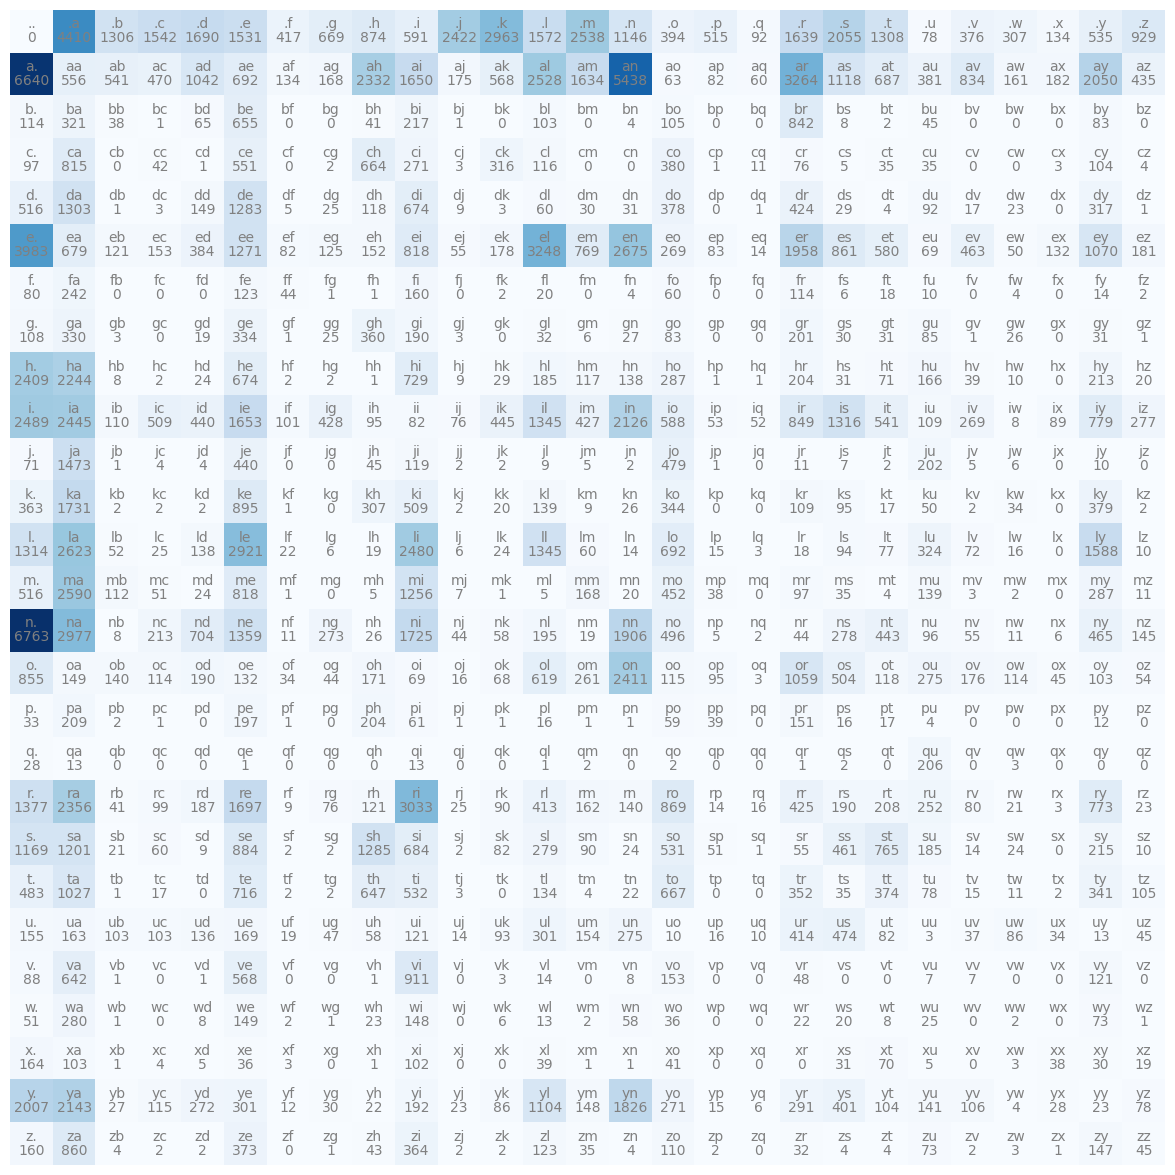

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 15))
plt.imshow(N, cmap="Blues")
for y in range(27):
    for x in range(27):
        plt.text(x, y, itos[y] + itos[x], ha="center", va="bottom", color="gray")
        plt.text(x, y, N[y, x].item(), ha="center", va="top", color="gray")
plt.axis("off");

In [12]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [13]:
p = N[0].float()
p /= p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [14]:
p.shape

torch.Size([27])

In [15]:
g = torch.Generator().manual_seed(2**31 - 1)
idx = torch.multinomial(p, 1, True, generator=g).item()
itos[idx]

'c'

In [16]:
P = (N + 1).float() 
P /= P.sum(1, True)

In [17]:
for _ in range(5):
    idx, out = 0, []
    while True:
        p = P[idx]
        idx = torch.multinomial(p, 1, True, generator=g).item()
        out.append(itos[idx])
        if idx == stoi["."]:
            break
    print("".join(out))

exze.
momasurailezitynn.
konimittain.
llayn.
ka.


In [18]:
log_likelihood, n = 0, 0
for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        prob = P[stoi[ch1], stoi[ch2]]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f"{ch1}{ch2}: {prob:.4f} {logprob:.4f}")
print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
print(nll / n)

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
tensor(2.4544)


In [20]:
# create the training set of bigrams
xs, ys = [], []

for w in words[:1]:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])
        print(ch1, ch2)

xs, ys = torch.tensor(xs), torch.tensor(ys)

. e
e m
m m
m a
a .


In [21]:
xs

tensor([ 0,  5, 13, 13,  1])

In [22]:
ys

tensor([ 5, 13, 13,  1,  0])

In [30]:
import torch.nn.functional as F
xenc = F.one_hot(xs, 27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [31]:
xenc.shape

torch.Size([5, 27])

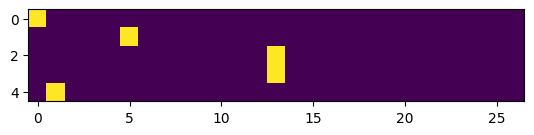

In [32]:
plt.imshow(xenc);

In [33]:
xenc.dtype

torch.float32

In [41]:
W = torch.randn((27, 27))
xenc @ W # (5, 27) @ (27, 27) -> (5, 27)

tensor([[ 0.3333,  0.8634, -0.6319,  1.5646,  0.5147,  0.1939,  0.7739,  0.5159,
         -0.7601, -0.3087, -0.3721, -0.6230,  0.7188,  1.0484,  1.2943, -0.7763,
          0.3467,  0.3132, -0.4191,  0.4040,  0.8579, -1.4056, -0.9985, -1.6716,
          2.0304, -0.4433,  0.0700],
        [ 1.0850,  0.0520,  0.3409, -1.1792, -1.3319, -0.2123,  0.4336,  0.4790,
         -0.6047,  0.7202,  0.5959, -0.3619, -1.0651,  0.3035,  0.3099,  1.1770,
          1.5829,  0.3534, -0.6667,  1.0796, -0.2555,  1.7109,  1.0198, -0.2656,
         -0.3465,  1.5929, -1.3978],
        [ 0.9008,  0.4350, -1.0703,  0.2314, -0.4312,  1.3690, -0.2868, -0.6904,
         -0.7858,  0.1897,  0.5785,  0.4663, -0.3606,  1.0876,  1.8003, -1.7815,
          1.4395,  0.0852,  0.4555,  0.3691, -1.4577, -0.3230, -0.8212, -0.4650,
          0.1634,  1.6012,  1.1443],
        [ 0.9008,  0.4350, -1.0703,  0.2314, -0.4312,  1.3690, -0.2868, -0.6904,
         -0.7858,  0.1897,  0.5785,  0.4663, -0.3606,  1.0876,  1.8003, -1.7815

In [53]:
logits = xenc @ W # log-counts
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, True)
probs

tensor([[0.0312, 0.0531, 0.0119, 0.1070, 0.0374, 0.0272, 0.0485, 0.0375, 0.0105,
         0.0164, 0.0154, 0.0120, 0.0459, 0.0639, 0.0817, 0.0103, 0.0317, 0.0306,
         0.0147, 0.0335, 0.0528, 0.0055, 0.0082, 0.0042, 0.1705, 0.0144, 0.0240],
        [0.0632, 0.0225, 0.0300, 0.0066, 0.0056, 0.0173, 0.0329, 0.0345, 0.0117,
         0.0439, 0.0387, 0.0149, 0.0074, 0.0289, 0.0291, 0.0693, 0.1039, 0.0304,
         0.0110, 0.0628, 0.0165, 0.1181, 0.0592, 0.0164, 0.0151, 0.1050, 0.0053],
        [0.0535, 0.0336, 0.0075, 0.0274, 0.0141, 0.0855, 0.0163, 0.0109, 0.0099,
         0.0263, 0.0388, 0.0347, 0.0152, 0.0645, 0.1315, 0.0037, 0.0917, 0.0237,
         0.0343, 0.0314, 0.0051, 0.0157, 0.0096, 0.0137, 0.0256, 0.1078, 0.0683],
        [0.0535, 0.0336, 0.0075, 0.0274, 0.0141, 0.0855, 0.0163, 0.0109, 0.0099,
         0.0263, 0.0388, 0.0347, 0.0152, 0.0645, 0.1315, 0.0037, 0.0917, 0.0237,
         0.0343, 0.0314, 0.0051, 0.0157, 0.0096, 0.0137, 0.0256, 0.1078, 0.0683],
        [0.0414, 0.0350,

In [54]:
probs[0].sum()

tensor(1.0000)

In [69]:
nlls = torch.zeros(5)
for i in range(5):
    x, y = xs[i].item(), ys[i].item()
    print("-" * 80)
    print(f"bigram_{i}: ({itos[x]}{itos[y]}) <-> ({x}, {y})")
    print(f"net input: {x}")
    print(f"net output: {probs[i]}")
    print(f"label: {y}")
    p = probs[i, y]
    print(f"prob_asigned to correct char: {p.item()}")
    logp = torch.log(p)
    print(f"log likelihood: {logp.item()}")
    nll = -logp
    print(f"negative log likelihood: {nll.item()}")
    nlls[i] = nll

print("-" * 80)
print(f"average negative log likelihood (loss): {nlls.mean().item()}")

--------------------------------------------------------------------------------
bigram_0: (.e) <-> (0, 5)
net input: 0
net output: tensor([0.0312, 0.0531, 0.0119, 0.1070, 0.0374, 0.0272, 0.0485, 0.0375, 0.0105,
        0.0164, 0.0154, 0.0120, 0.0459, 0.0639, 0.0817, 0.0103, 0.0317, 0.0306,
        0.0147, 0.0335, 0.0528, 0.0055, 0.0082, 0.0042, 0.1705, 0.0144, 0.0240])
label: 5
prob_asigned to correct char: 0.02716969884932041
log likelihood: -3.6056530475616455
negative log likelihood: 3.6056530475616455
--------------------------------------------------------------------------------
bigram_1: (em) <-> (5, 13)
net input: 5
net output: tensor([0.0632, 0.0225, 0.0300, 0.0066, 0.0056, 0.0173, 0.0329, 0.0345, 0.0117,
        0.0439, 0.0387, 0.0149, 0.0074, 0.0289, 0.0291, 0.0693, 0.1039, 0.0304,
        0.0110, 0.0628, 0.0165, 0.1181, 0.0592, 0.0164, 0.0151, 0.1050, 0.0053])
label: 13
prob_asigned to correct char: 0.028915483504533768
log likelihood: -3.5433781147003174
negative log like